In [7]:
import torch
import os
import matplotlib.pyplot as plt
from typing import Tuple
from torch.utils.data import DataLoader
import torchvision.datasets
from preprocess_dataset import *
import torchvision.transforms as TF
import torch.nn as nn
import field_geometry
import losses 
from main_network import DecompositionNetwork
import network
import train_eval
from tqdm import tqdm
import visualize_primitive
import importlib
from typing import Dict
import random
import numpy
import utils

In [8]:
# Hyperparameters:
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_EPOCHS = 50
LOAD_MODEL = False
NUM_WORKERS = os.cpu_count()

In [9]:
train_dataloader = cad_train_dataloader(NUM_WORKERS)
test_dataloader = cad_val_dataloader(NUM_WORKERS)

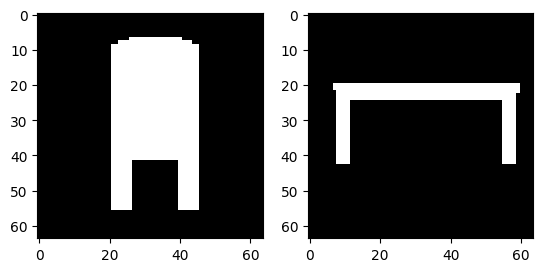

In [10]:
for image, mask in test_dataloader:
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image[0].squeeze(), cmap="gray")
    ax2.imshow(image[1].squeeze(), cmap="gray")
    break

In [14]:
# triangles and squares are not defined yet
importlib.reload(train_eval)
image_size = [64, 64]
model = network.Model(
    img_size=image_size,
    conv_channels=(1, 16, 8),
    dense_layers=(2048,),
    num_recs=8,
    num_circs=0
)
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

{'Rectangle': 8, 'Circle': 0}


In [15]:
utils.load_model_param(model, "cad_8recs_0circs__16_8_conv_50epoch")


========== Loading Model Parameters ==========


In [7]:
(cov_loss, cons_rect_train_loss, cons_circ_train_loss) = train_eval.train_model(
    NUM_EPOCHS, train_dataloader, train_eval.extract_cad, model, NUM_EPOCHS//2, BATCH_SIZE, optim, DEVICE
)

100%|██████████| 78/78 [00:07<00:00, 11.07it/s, loss=all losses: 0.01323 union cov loss: 0.00695 cons_loss_rect 0.00628 cons_loss circle 0.00000]


In [8]:
# importlib.reload(utils)
# # save model
# utils.save_model_param(model, "cad_8recs_0circs__16_8_conv_50epoch")

========== Saving Model Parameters ==========


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


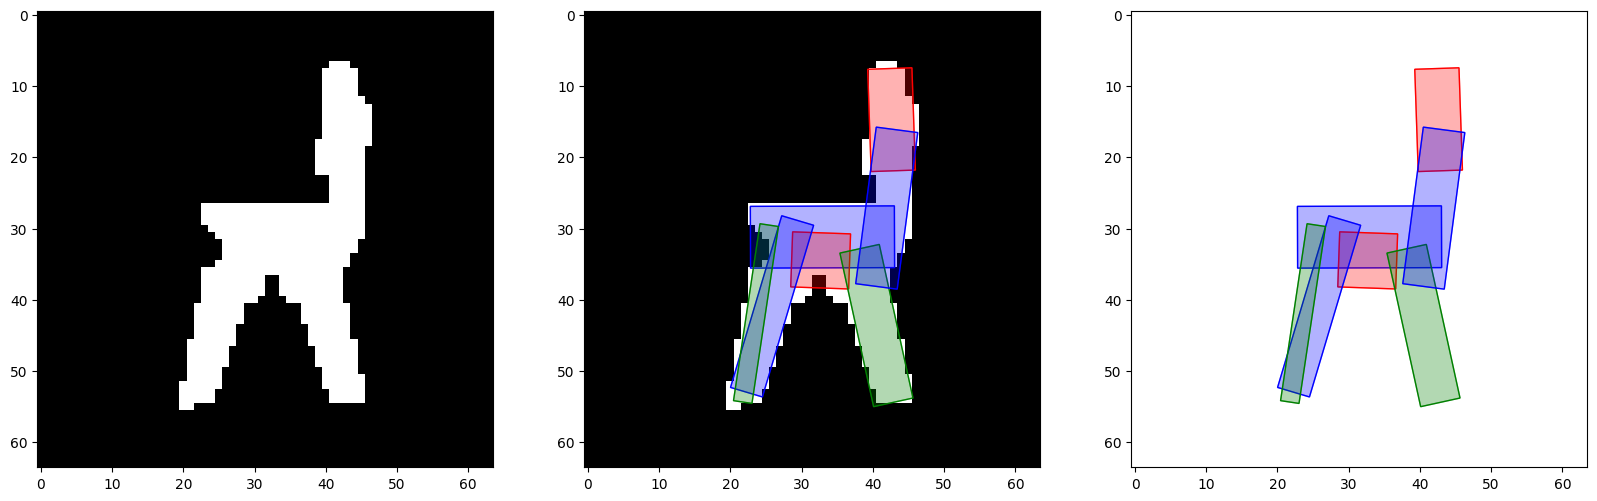

In [68]:
importlib.reload(visualize_primitive)

# _, ax = plt.subplots(1,3, figsize=(10,10))
for data, target in test_dataloader:
    
    with torch.no_grad():
        r, rp,r_rot,  c, cp = train_eval.unpack_model_output(
                model.num_dict, 
                model(data.float())
                )
        z_rec = (rp > 0.5)
        # z_circ = (cp > 0.5)

    img_size=data[0].squeeze().size()
    # plot
    idx=43
    _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
    ax1.imshow(data[idx].permute(1, 2, 0), cmap="gray")
    ax2.imshow(data[idx].permute(1, 2, 0), cmap="gray")
    zeros = torch.ones(size=(*img_size, 3)) * 255
    ax3.imshow(zeros)

    visualize_primitive.plot_rotated_rectangles(ax2, r[idx, z_rec[idx]], r_rot[idx, z_rec[idx]], img_size)
    # visualize_primitive.plot_rotated_rectangles(ax1, r[idx, ~z_rec[idx]], r_rot[idx, ~z_rec[idx]],  img_size)
    visualize_primitive.plot_rotated_rectangles(ax3, r[idx, z_rec[idx]], r_rot[idx, z_rec[idx]], img_size)
    # visualize_primitive.plot_circles(ax1, c[0, z_circ[0]], img_size)
    # visualize_primitive.plot_circles(ax2, c[0, ~z_circ[0]], img_size)
    # visualize_primitive.plot_circles(ax3, c[0], img_size)
    # ax1.set(title="Selected")
    # ax2.set(title="Unselected")
    # ax3.set(title="Select all")
    break



In [13]:
import importlib

importlib.reload(train_eval)

IoU_list = []

for data, target in test_dataloader:
    with torch.no_grad():
        data = (data > 0) * 1
        r, rp,r_rot,  c, cp = train_eval.unpack_model_output(
                model.num_dict, 
                model(data.float())
                )
        z_rec = (rp > 0.5)

    img_size=data[0].squeeze().size()
    
    # set mask value to < 1 for better IoU score
    IoU_score = train_eval.IoU(r, r_rot, rp, c, cp, 0, data, device="cpu", mode="batch")
    IoU_list.append(IoU_score)

print(sum(IoU_list) / len(IoU_list))

tensor(0.2851)


/tmp/ipykernel_9661/3661436410.py:11: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax[2].set_ylim([0, cons_loss_circ_stacked.max()])


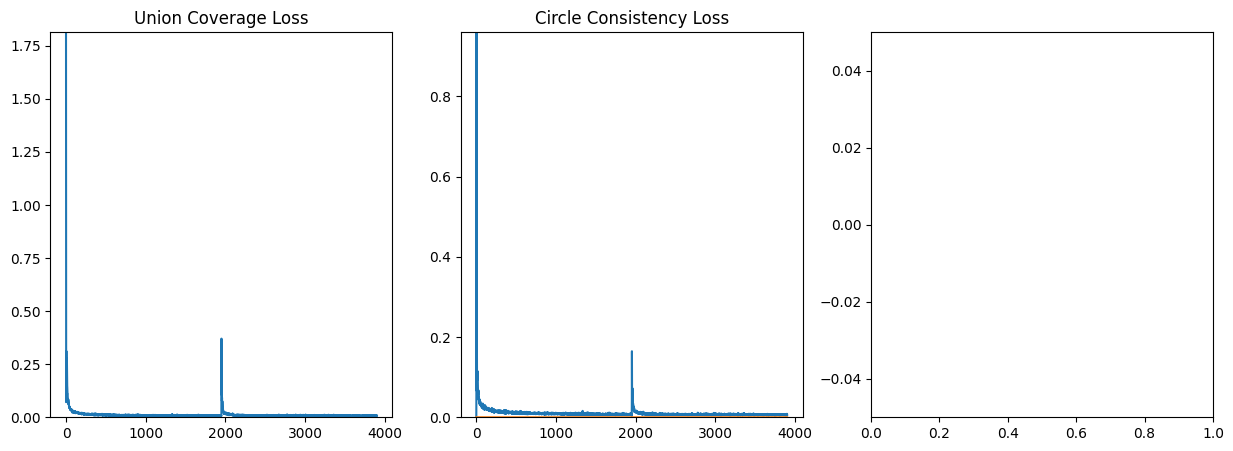

In [11]:
#(cov_loss, cons_rect_train_loss, cons_circ_train_loss)
_, ax = plt.subplots(1, 3, figsize=(15, 5))
cov_loss_stacked = torch.tensor([cov_loss]).flatten()
cons_loss_rect_stacked = torch.tensor([cons_rect_train_loss]).flatten()
cons_loss_circ_stacked = torch.tensor([cons_circ_train_loss]).flatten()


# ax[0].set_ylim([0, cov_loss_stacked.max()])
ax[0].set_ylim([0, cov_loss_stacked.max()])
ax[1].set_ylim([0, cons_loss_rect_stacked.max()])
ax[2].set_ylim([0, cons_loss_circ_stacked.max()])

# ax[3].set_ylim([0, intersect_loss_stacked.max()])
ax[0].set_title("Union Coverage Loss")
ax[0].plot(cov_loss_stacked)
ax[1].set_title("Rectangle Consistency Loss")
ax[1].plot(cons_loss_rect_stacked)
ax[1].set_title("Circle Consistency Loss")
ax[1].plot(cons_loss_circ_stacked)

plt.show()


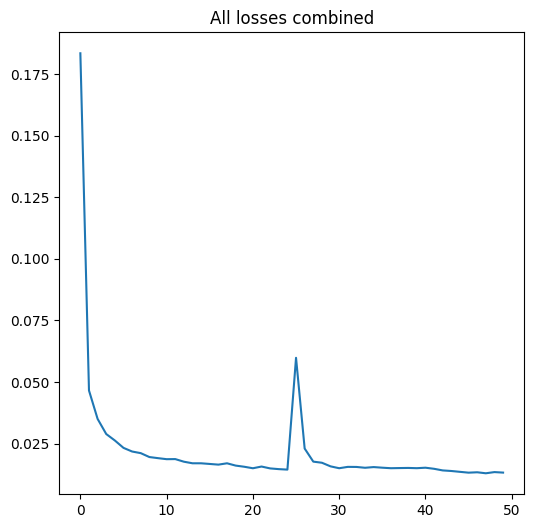

In [12]:
mean_losses = []
for union_cov, rect_cons, circ_cons in zip(cov_loss, cons_rect_train_loss, cons_circ_train_loss):
    mean_losses.append(
        (
            sum(union_cov) / len(union_cov) 
            + sum(rect_cons) / len(rect_cons) 
            + sum(circ_cons) / len(circ_cons)
        )
    )
mean_losses = torch.stack(mean_losses).detach().cpu()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("All losses combined")
ax.plot(mean_losses)
plt.show()
